# Bureau of Labor Statistics Time Series Forecasting
## Restaurants & Other Eating Places NAICS CODE: 7225

### Steps
**Step 1:** Import data, look at two different series<br>
- Restaurant Production Non-Supervisory Employees
  - rw: Before March, 2020
  - rw_original: Full dataset
  - rw_actual: March, 2020 - Present
- Private Employees
  - pe: Before March, 2020
  - pe_original: Full dataset
  - pe_actual: March, 2020 - Present<br>
**Step 2:** Check stationarity for both datasets<br>
**Step 3:** Check ACF & PACF<br>
**Step 4:** Run ARIMA Time Series, plot against actual, compare actual and forecasted dataframes<br>
**Step 5:** Plot restaurant workers as a percentage of total private sector for forecasted and actual data<br>
**Step 6:** Linear Regression of x = rw, y = pe, created predicted dataset from linear regression<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.tsatools import detrend
from sklearn.linear_model import LinearRegression
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

### Step 1: Import Data

In [2]:
df = pd.read_csv('bls_722500.csv', index_col=0, parse_dates=True)
df.head()

,Restaurant Employees (thousands),Restaurant Avg. Hourly,Restaurant Avg. Weekly,Restaurant PNS Employees (thousands),Restaurant PNS Avg. Hourly,Restaurant PNS Avg. Weekly,Private Employees (thousands),Private Avg. Hourly,Private Avg. Weekly,Private PNS Employees (thousands),Private PNS Avg. Hourly,Private PNS Avg. Weekly,Total Employees (thousands)
Date,,,,,,,,,,,,,
2013-01-01,9238.5,11.73,300.29,8241.3,10.47,256.52,113394.0,23.76,817.34,93659.0,19.94,669.98,135263.0
2013-02-01,9267.0,11.76,302.23,8266.0,10.50,257.25,113660.0,23.77,820.07,93870.0,19.99,675.66,135541.0
2013-03-01,9285.8,11.77,301.31,8289.2,10.51,257.50,113810.0,23.81,821.45,94001.0,20.01,676.34,135680.0
2013-04-01,9318.7,11.77,301.31,8310.5,10.52,257.74,114002.0,23.87,821.13,94155.0,20.04,675.35,135871.0
2013-05-01,9362.8,11.79,301.82,8360.8,10.55,258.48,114229.0,23.89,824.21,94302.0,20.05,675.69,136093.0


In [3]:
rw = df['Restaurant PNS Employees (thousands)'][:'2020-02-01']
rw_original = df['Restaurant PNS Employees (thousands)']
rw_actual = df['Restaurant PNS Employees (thousands)']['2020-03-01':]

pe = df['Private Employees (thousands)'][:'2020-02-01']
pe_original = df['Private Employees (thousands)']
pe_actual = df['Private Employees (thousands)']['2020-03-01':]

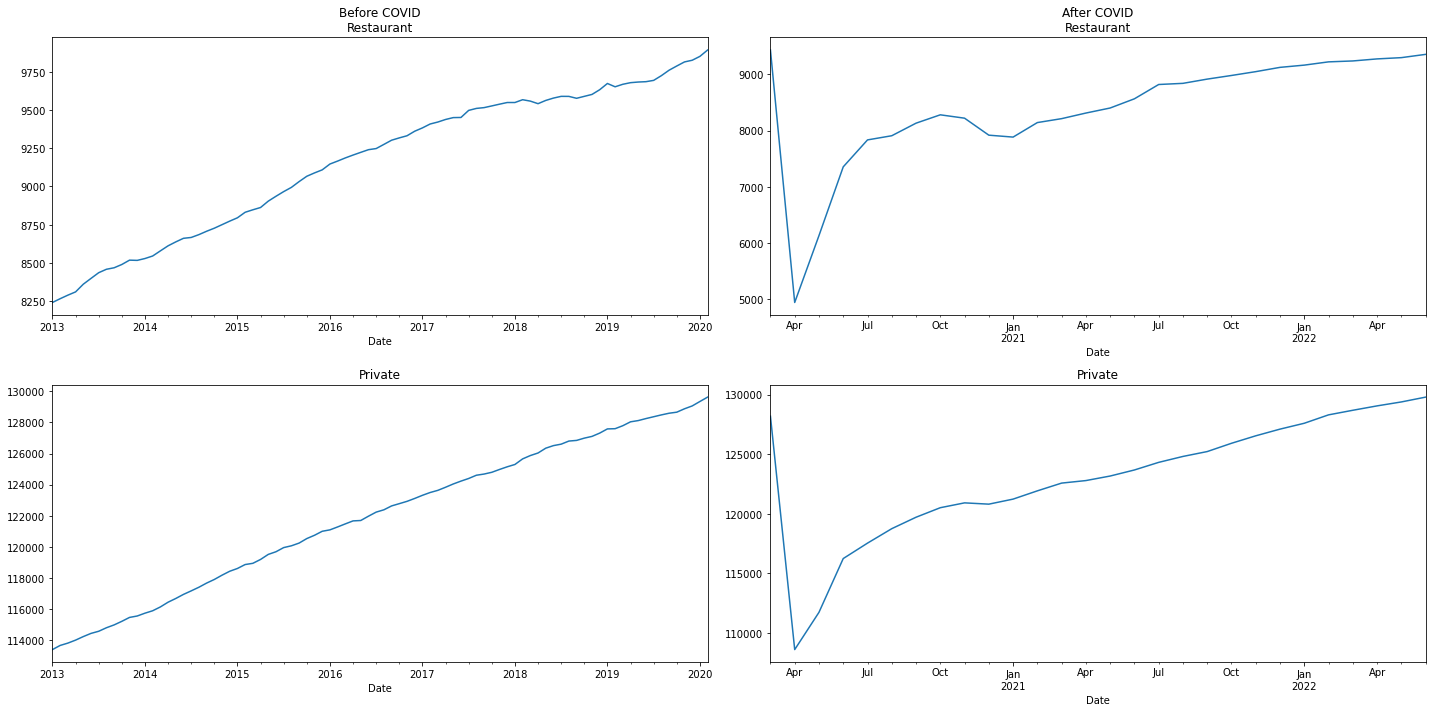

In [4]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))
rw.plot(legend=False, title='Before COVID\nRestaurant', ax=ax[0, 0])
pe.plot(legend=False, title='Private', ax=ax[1,0])
rw_actual.plot(legend=False, title='After COVID\nRestaurant', ax=ax[0, 1])
pe_actual.plot(legend=False, title='Private', ax=ax[1, 1])
plt.tight_layout()
plt.show()

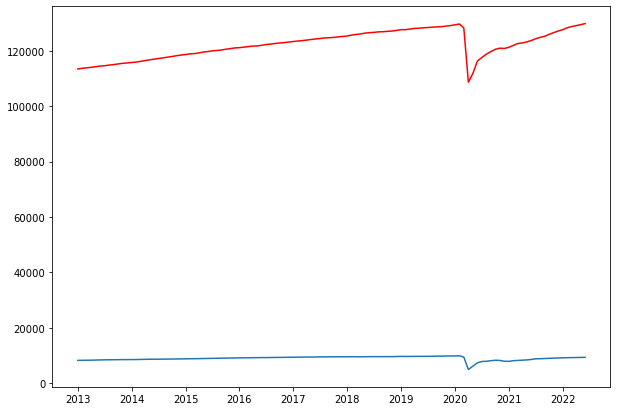

In [5]:
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(rw_original)
plt.plot(pe_original, color='red')

### Step 2: Check Stationarity
We'll be using rw & pe, because we are going to use pre-COVID data to make a predicted data set

In [6]:
# Function to check stationarity using both KPSS & Adfuller
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-Stationary'
    
    if adf_pv < 0.05:
        # Reject ADF null hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS null hypothesis
        kpssh = 'Non-Stationary'
    return(kpssh, adfh)

In [7]:
# Function to plot stationarity based on the method used

def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n, 2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2
        
        kpss_s, adf_s = check_stationarity(method)
        method.plot(kind=plot_type,
                    ax=ax[v,r],
                    legend=False,
                    title=f'{name[0]} --> KPSS: {kpss_s}, ADF: {adf_s}')
        ax[v, r].title.set_size(20)
        method.rolling(12).mean().plot(ax=ax[v, r], legend=False)

**Check Stationarity for rw**

In [8]:
# First order differencing
first_order_diff = rw.diff().dropna()
# Second order differencing
second_order_diff = rw.diff(12).diff().dropna()
# Subtract moving average
rolling = rw.rolling(12).mean()
sub_moving_average = rw - rolling
# Log transform
log_transform = np.log(rw)
# Decomposition
decomp = seasonal_decompose(rw)
sd_detrend = decomp.observed - decomp.trend
# Hodrick-Prescott filter
cyclic, trend = hpfilter(rw)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/s

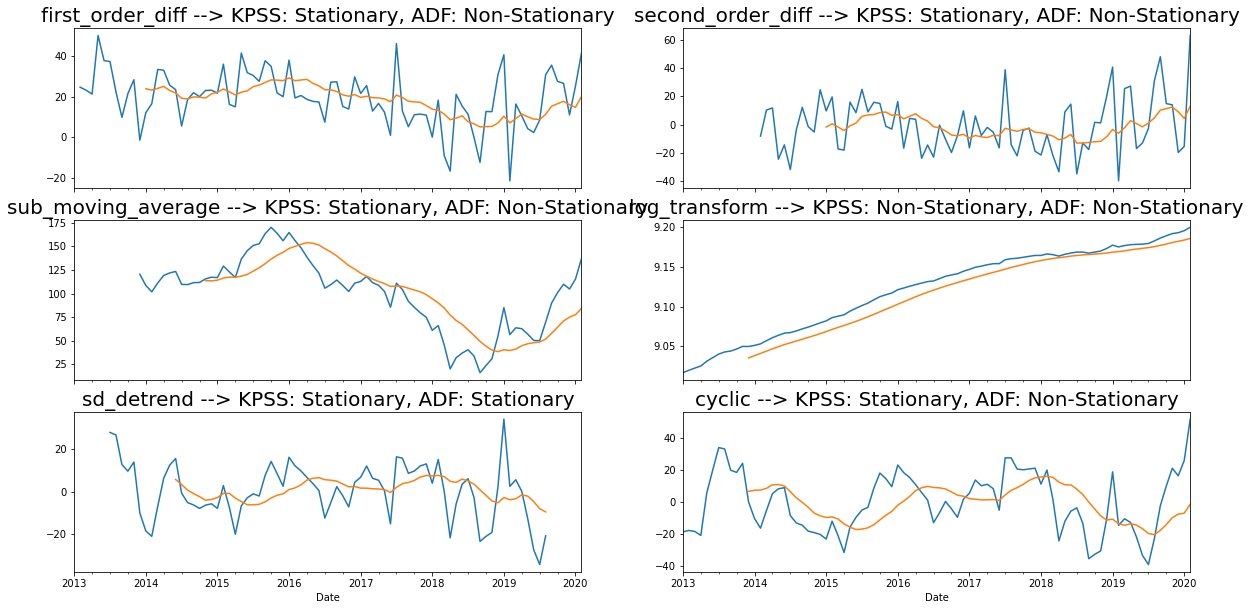

In [9]:
methods = [first_order_diff, second_order_diff, sub_moving_average,
           log_transform, sd_detrend, cyclic]
plot_comparison(methods)

In [10]:
# Seasonal Detrend looks most stationary for rw
rw_stat = sd_detrend

**Check stationarity for pe**

In [11]:
# First order differencing
first_order_diff = pe.diff().dropna()
# Second order differencing
second_order_diff = pe.diff(12).diff().dropna()
# Subtract moving average
rolling = pe.rolling(12).mean()
sub_moving_average = pe - rolling
# Log transform
log_transform = np.log(pe)
# Decomposition
decomp = seasonal_decompose(pe)
sd_detrend = decomp.observed - decomp.trend
# Hodrick-Prescott filter
cyclic, trend = hpfilter(pe)

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/s

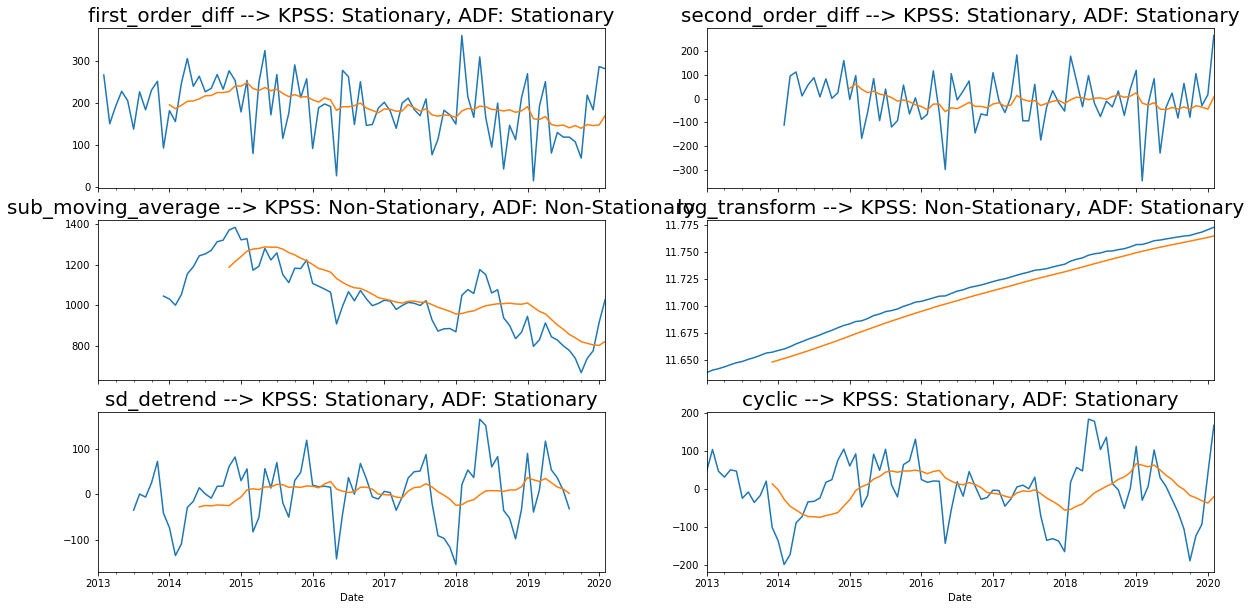

In [12]:
methods = [first_order_diff, second_order_diff, sub_moving_average,
           log_transform, sd_detrend, cyclic]
plot_comparison(methods)

In [13]:
# first_order_diff is sufficient for pe
pe_stat = first_order_diff

### Step 3: Check Autocorrelation and Partial Autocorrelation

**ACF & PACF for rw**

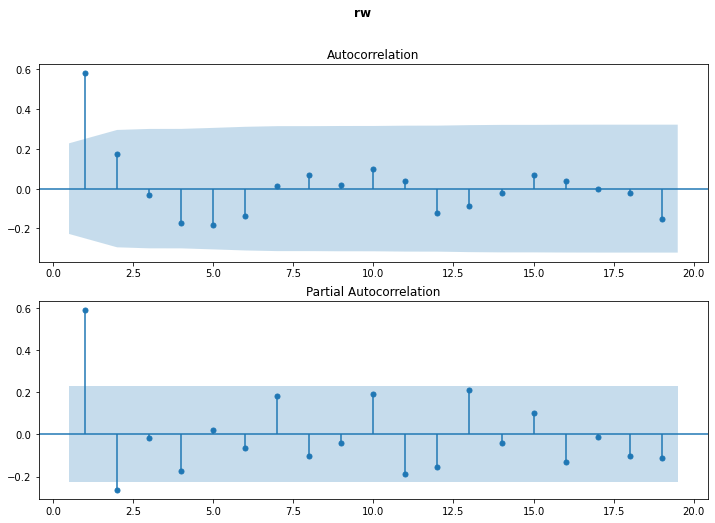

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(rw_stat, zero=False, ax=ax[0])
plot_pacf(rw_stat, zero=False, ax=ax[1])
fig.suptitle('rw', fontweight='bold')
plt.show()

Only one ACF spike is significant, indicating a MA(1)

**ACF & PACF for pe**

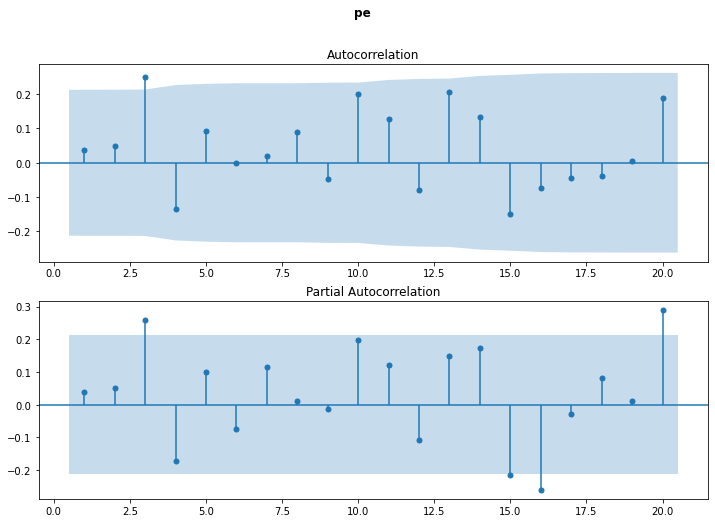

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(pe_stat, zero=False, ax=ax[0])
plot_pacf(pe_stat, zero=False, ax=ax[1])
fig.suptitle('pe', fontweight='bold')
plt.show()

Only one ACF spike is significant, indicating a MA(3)

### Step 4: ARIMA Time Series

In [16]:
# Function to split data into test and train

def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[:t_idx], data[t_idx:]
    print(f'train: {len(train)}, test: {len(test)}')
    return train, test

In [17]:
# Function to see if ARIMA is a good model

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [18]:
# Function to plot full forecast after model fits

def full_forecast(model, start, train, test, original, actual):
    forecast = pd.DataFrame(model.forecast(original.shape[0]), index=original.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style='-.')
    actual.plot(ax=ax, style=':')
    ax.legend(['orig_train', 'orig_test', 'forecast', 'actual'])
    plt.show()

In [19]:
# Split the data into test, train datasets

test_split = 0.15
rw_train, rw_test = split_data(rw, test_split)
pe_train, pe_test = split_data(pe, test_split)

train: 73, test: 13
train: 73, test: 13


#### Test ARIMA re

In [20]:
model = ARIMA(rw_train, order=(1, 1, 1))
results = model.fit()
results.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:     Restaurant PNS Employees (thousands)   No. Observations:                   73
Model:                                   ARIMA(1, 1, 1)   Log Likelihood                -283.063
Date:                                  Tue, 06 Sep 2022   AIC                            572.125
Time:                                          19:27:46   BIC                            578.955
Sample:                                      01-01-2013   HQIC                           574.844
                                           - 01-01-2019                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9937      0.011     86.414      0.000       0.971       1.016
ma.L1         -0.7967      0.076    -10.524      0.000      -0.945      -0.648
sigma2       148.2580     24.082      6.156      0.000     101.059     195.457
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):                 1.11
Prob(Q):                              0.26   Prob(JB):                         0.57
Heteroskedasticity (H):               1.83   Skew:                             0.29
Prob(H) (two-sided):                  0.15   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Ljung Box test

In [21]:
(acorr_ljungbox(results.resid, lags=25, return_df=True) < 0.05)['lb_pvalue'].sum()

0

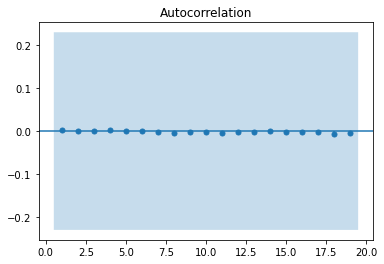

In [22]:
plot_acf(results.resid, zero=False)
plt.show()

Pass

##### ARIMA re

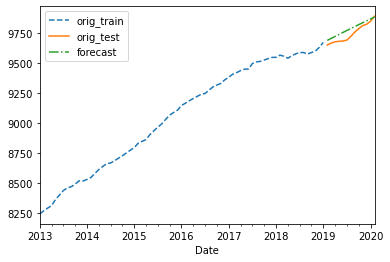

In [23]:
plot_forecast(results, '2013', rw_train, rw_test)

Pass. ARIMA model fits for re

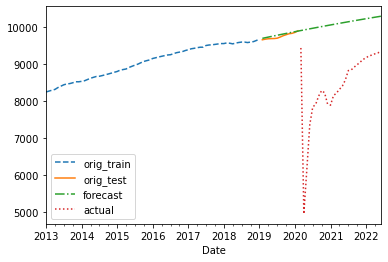

In [24]:
full_forecast(results, '2013', rw_train, rw_test, rw_original, rw_actual)

In [25]:
# Create a dataframe from forecast model

rw_forecast = pd.Series(results.forecast(rw_original.shape[0]), index=rw_original.index)
rw_forecast.tail()

Date
2022-02-01    10234.870709
2022-03-01    10248.281166
2022-04-01    10261.606894
2022-05-01    10274.848426
2022-06-01    10288.006295
Name: predicted_mean, dtype: float64

#### Test ARIMA pe

In [26]:
model = ARIMA(pe_train, order=(1, 1, 3))
results = model.fit()
results.summary()

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:     Private Employees (thousands)   No. Observations:                   73
Model:                            ARIMA(1, 1, 3)   Log Likelihood                -403.569
Date:                           Tue, 06 Sep 2022   AIC                            817.138
Time:                                   19:27:47   BIC                            828.522
Sample:                               01-01-2013   HQIC                           821.670
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9973      0.003    395.883      0.000       0.992       1.002
ma.L1         -0.9206      0.140     -6.570      0.000      -1.195      -0.646
ma.L2         -0.1315      0.173     -0.760      0.447      -0.471       0.207
ma.L3          0.1003      0.131      0.766      0.444      -0.157       0.357
sigma2      4352.7187    671.597      6.481      0.000    3036.413    5669.024
===================================================================================
Ljung-Box (L1) (Q):                   0.58   Jarque-Bera (JB):                 1.75
Prob(Q):                              0.45   Prob(JB):                         0.42
Heteroskedasticity (H):               2.01   Skew:                            -0.23
Prob(H) (two-sided):                  0.09   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
(acorr_ljungbox(results.resid, lags=25, return_df=True) < 0.05)['lb_pvalue'].sum()

0

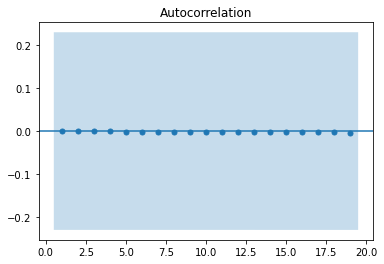

In [28]:
plot_acf(results.resid, zero=False)
plt.show()

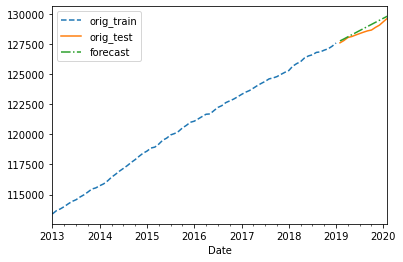

In [29]:
plot_forecast(results, '2013', pe_train, pe_test)

Pass. ARIMA model fits for pe

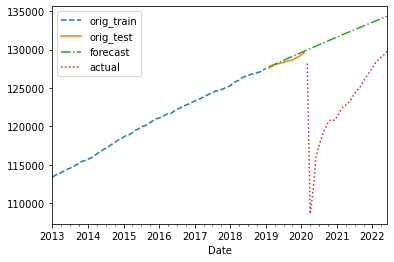

In [30]:
full_forecast(results, '2013', pe_train, pe_test, pe_original, pe_actual)

In [31]:
pe_forecast = pd.Series(results.forecast(pe_original.shape[0]), index=pe_original.index)
pe_forecast.tail()

Date
2022-02-01    133720.868786
2022-03-01    133878.734825
2022-04-01    134036.176093
2022-05-01    134193.193735
2022-06-01    134349.788889
Name: predicted_mean, dtype: float64

### Step 5: Percent Changes

In [32]:
pct_original = (rw_original / pe_original) * 100
pct_forecast = (rw_forecast / pe_forecast) * 100

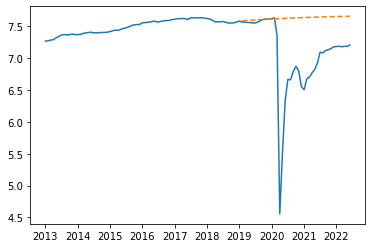

In [33]:
plt.plot(pct_original)
plt.plot(pct_forecast, linestyle='--')

In [34]:
pct_original.tail()

Date
2022-02-01    7.186952
2022-03-01    7.178116
2022-04-01    7.185776
2022-05-01    7.184705
2022-06-01    7.207107
dtype: float64

In [35]:
pct_forecast.tail()

Date
2022-02-01    7.653907
2022-03-01    7.654898
2022-04-01    7.655849
2022-05-01    7.656758
2022-06-01    7.657627
Name: predicted_mean, dtype: float64

In [36]:
100 - ((pct_original[-1] / pct_forecast[-1]) * 100)

5.883286857861918

### Step 6: Linear Regression

In [37]:
x = df[['Private Employees (thousands)']][:'2020-02-01']
y = df[['Restaurant PNS Employees (thousands)']][:'2020-02-01']

In [38]:
y.shape

(86, 1)

In [39]:
linreg = LinearRegression()
linreg.fit(x, y)
print(f'Intercept: {linreg.intercept_}')
print(f'Coefficient: {linreg.coef_[0]}')

Intercept: [-2845.49357568]
Coefficient: [0.0984754]


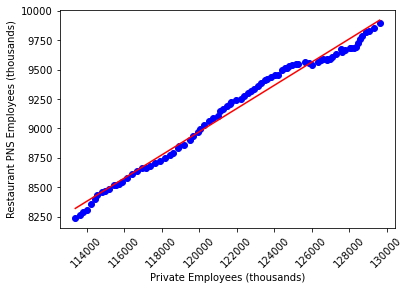

In [40]:
plt.scatter(x, y, color='blue')
plt.plot(x, linreg.predict(x), color='red')
plt.xticks(rotation=45)
plt.xlabel('Private Employees (thousands)')
plt.ylabel('Restaurant PNS Employees (thousands)')
plt.show()

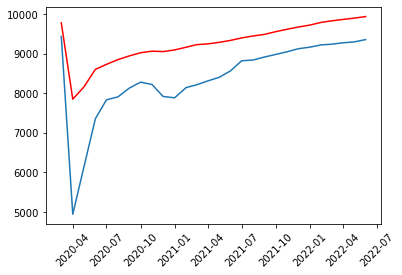

In [41]:
reg_pred = pe_actual.apply(lambda x:
                          x*0.0984754 - 2845.49357568)
plt.plot(reg_pred, color='red')
plt.plot(rw_actual)
plt.xticks(rotation=45)
plt.show()

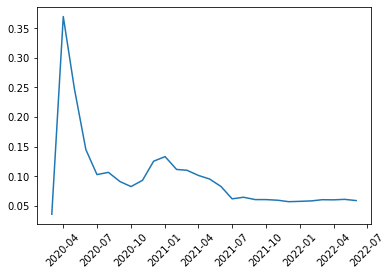

In [42]:
pct_diff = 1 - (rw_actual / reg_pred)
plt.xticks(rotation=45)
plt.plot(pct_diff)

In [43]:
pct_diff['2021-10-01':].mean() * 100

5.889929286785049